In [67]:
import numpy as np
# import scanpy.api as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ete3 import Tree
import networkx as nx

import pickle as pic

from tqdm import tqdm_notebook
from tqdm import tqdm

import utilities.metastasis_score_utils as met_utils
from cassiopeia.TreeSolver import data_pipeline
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
import cassiopeia.TreeSolver.post_process_tree as ppt


In [81]:
dfAT = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/ALL.5k.FINISHED.alleleTable.txt", sep='\t')
meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

tree_scores = pd.read_csv("data/lg_metastatic_scores.txt", sep='\t', index_col = 0)

,Static,Dynamic,NearestNeighbor
21,0.700000,0.080160,0.725753
100,0.658950,0.066038,0.538462
56,0.713620,0.085202,0.625000
80,0.405788,0.037736,0.285714
19,0.720413,0.044898,0.653251


In [69]:
# calculate % cut across the trees

dfAT_rtot = dfAT.groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r.tot'})
dfAT_r1unc = dfAT[dfAT['r1.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r1.uncut'})
dfAT_r2unc = dfAT[dfAT['r2.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r2.old":'count'}).rename(index=str, columns={'r2.old':'r2.uncut'})
dfAT_r3unc = dfAT[dfAT['r3.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r3.old":'count'}).rename(index=str, columns={'r3.old':'r3.uncut'})

dfCUT = pd.concat([dfAT_rtot,dfAT_r1unc,dfAT_r2unc,dfAT_r3unc], axis=1)
dfCUT = dfCUT.fillna(0)
dfCUT = dfCUT.sort_values("LineageGroup")

dfCUT['r1.cut%'] = 1-(dfCUT['r1.uncut']/dfCUT['r.tot'])
dfCUT['r2.cut%'] = 1-(dfCUT['r2.uncut']/dfCUT['r.tot'])
dfCUT['r3.cut%'] = 1-(dfCUT['r3.uncut']/dfCUT['r.tot'])

dfCUT['cut%'] = (dfCUT['r1.cut%']+dfCUT['r2.cut%']+dfCUT['r3.cut%'])/3

X1 = dfCUT.groupby(['LineageGroup']).agg({'r1.cut%':'mean'})
X2 = dfCUT.groupby(['LineageGroup']).agg({'r2.cut%':'mean'})
X3 = dfCUT.groupby(['LineageGroup']).agg({'r3.cut%':'mean'})

XCUT = pd.concat([X1,X2,X3], axis=1).reset_index()
XCUT.LineageGroup = pd.to_numeric(XCUT.LineageGroup, errors='coerce')
XCUT = XCUT.sort_values("LineageGroup").set_index("LineageGroup")

tree_stats = pd.DataFrame(XCUT.sum(1)/3, columns=['CutRate'])

In [70]:
def set_depth(tree, root):
    
    for n in tree.nodes:
            
        tree.nodes[n]['depth'] = nx.shortest_path_length(tree, root, n)
        
    return tree 

lg_to_tree = {}
lg_to_cm = {}
i = 0
for tree_dir in tqdm(os.listdir("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/")):
    tree_dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.processed.pkl" in fp and 'nj' not in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.alleleThresh.txt" in fp]
    if len(fps) > 0:
            try:
                tree = nx.read_gpickle(tree_dir + fps[0])
                lg_to_tree[int(lg)] = tree
                
                lg_to_cm[int(lg)] = pd.read_csv(tree_dir + cmfp[0], sep='\t', index_col = 0, dtype=str)
            except:
                print(lg)
                i += 1
print(i)    


    
    



  0%|          | 0/113 [00:00<?, ?it/s]

  2%|▏         | 2/113 [00:00<00:08, 13.03it/s]

  3%|▎         | 3/113 [00:00<00:12,  8.64it/s]

  4%|▎         | 4/113 [00:00<00:26,  4.14it/s]

  4%|▍         | 5/113 [00:01<00:22,  4.80it/s]

  5%|▌         | 6/113 [00:01<00:26,  4.09it/s]

  6%|▌         | 7/113 [00:01<00:22,  4.74it/s]

  7%|▋         | 8/113 [00:02<00:37,  2.83it/s]

  8%|▊         | 9/113 [00:02<00:34,  3.04it/s]

  9%|▉         | 10/113 [00:02<00:30,  3.37it/s]

 10%|▉         | 11/113 [00:02<00:27,  3.75it/s]

 11%|█         | 12/113 [00:02<00:22,  4.44it/s]

 12%|█▏        | 13/113 [00:03<00:22,  4.50it/s]

 12%|█▏        | 14/113 [00:03<00:18,  5.22it/s]

 14%|█▍        | 16/113 [00:03<00:14,  6.61it/s]

 16%|█▌        | 18/113 [00:03<00:13,  6.88it/s]

 19%|█▊        | 21/113 [00:04<00:14,  6.22it/s]

 20%|██        | 23/113 [00:04<00:12,  7.17it/s]

 21%|██        | 24/113 [00:04<00:12,  7.29it/s]

 22%|██▏       | 25/113 [00:04<00:15,  5.84it/s]

 24%|██▍       

0


In [71]:
complexities = {}
depths = {}
cell_counts = {}
for lg in tqdm_notebook(lg_to_tree.keys()):
    
    uniq_states[lg] = lg_to_cm[lg].drop_duplicates().shape[0] / lg_to_cm[lg].shape[0]
    
    tree_complexity = met_utils.compute_tree_complexity(lg_to_tree[lg].network)
    complexities[lg] = tree_complexity[0]
    
    tree = lg_to_tree[lg].network
    
    
    leaves = [n for n in tree if tree.out_degree(n) == 0]
    root = [n for n in tree if tree.in_degree(n) == 0][0]
    
    tree = set_depth(tree, root)
    _depths = [tree.nodes[n]['depth'] for n in leaves]
    
    depths[lg] = np.mean(_depths)
    cell_counts[lg] = lg_to_cm[lg].shape[0]

In [85]:
tree_stats['UniqStates'] = 0
tree_stats['Complexity'] = 0
tree_stats['Depths'] = 0
tree_stats['CellCounts'] = 0
tree_stats['MetScore'] = 0
for i in cut_rates.index:
    
    if i not in uniq_states.keys():
        continue 
        
    tree_stats.loc[i, 'UniqStates'] = uniq_states[i]
    if i in complexities.keys():
        tree_stats.loc[i, 'Complexity'] = complexities[i]
        
    tree_stats.loc[i, 'Depths'] = depths[i]
    tree_stats.loc[i, 'CellCounts'] = cell_counts[i]
    
    if i in tree_scores.index:
        tree_stats.loc[i, 'MetScore'] = tree_scores.loc[i,'Dynamic']

{65, 33, 5, 69, 38, 39, 41, 75, 16, 81, 18, 50, 53, 87, 88, 25, 93} 17


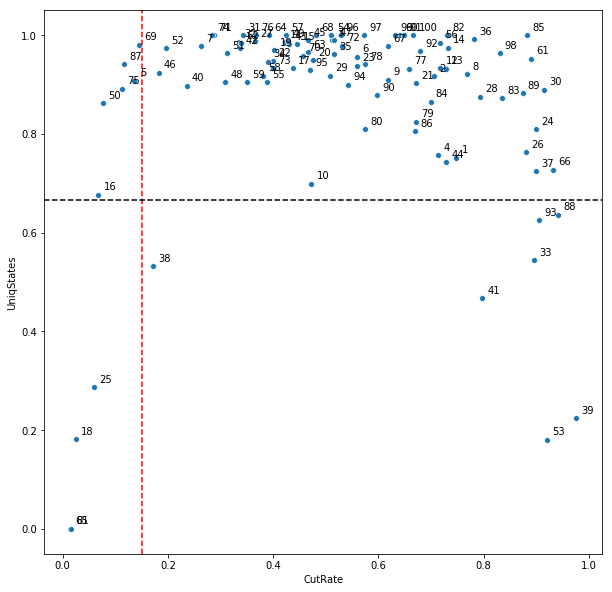

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2


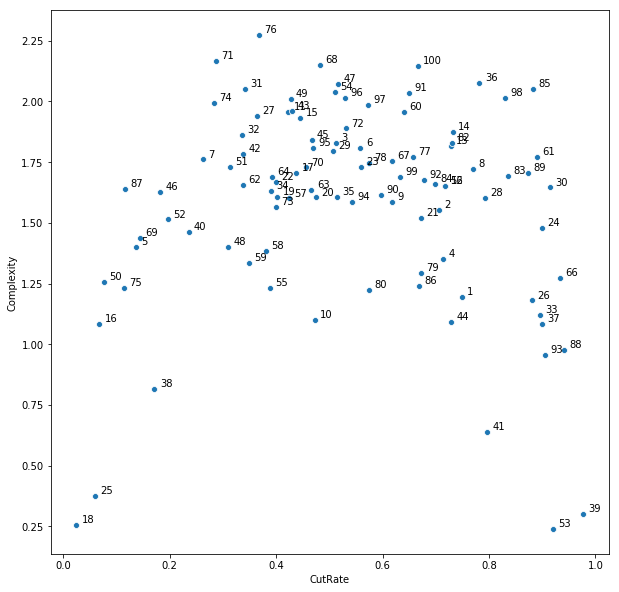

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log2


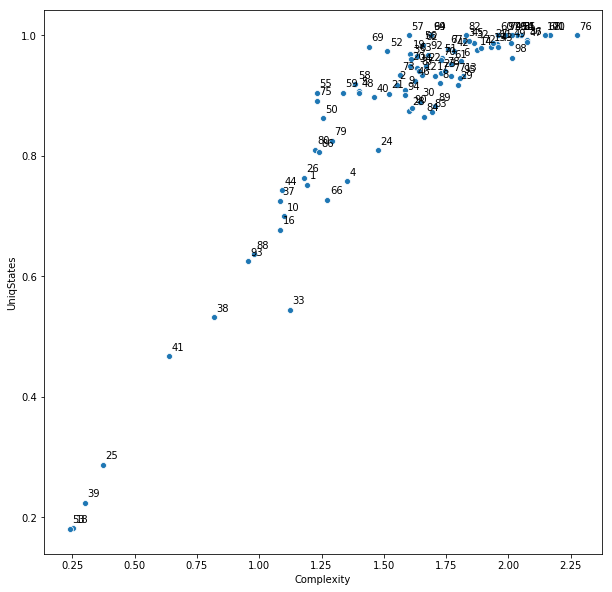

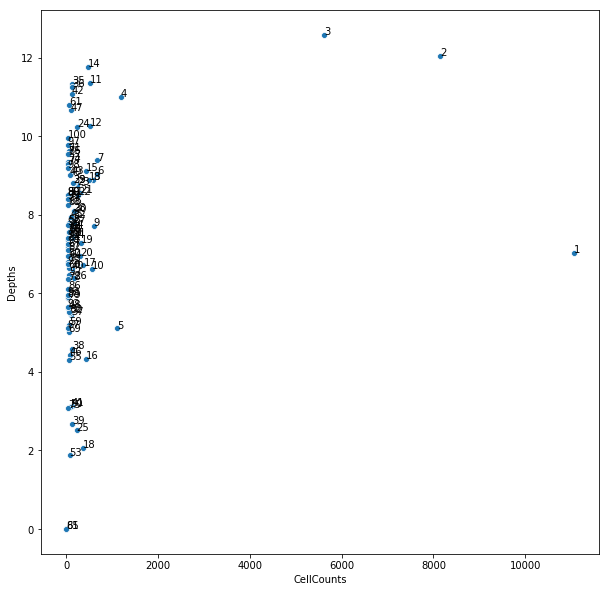

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log2
/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2


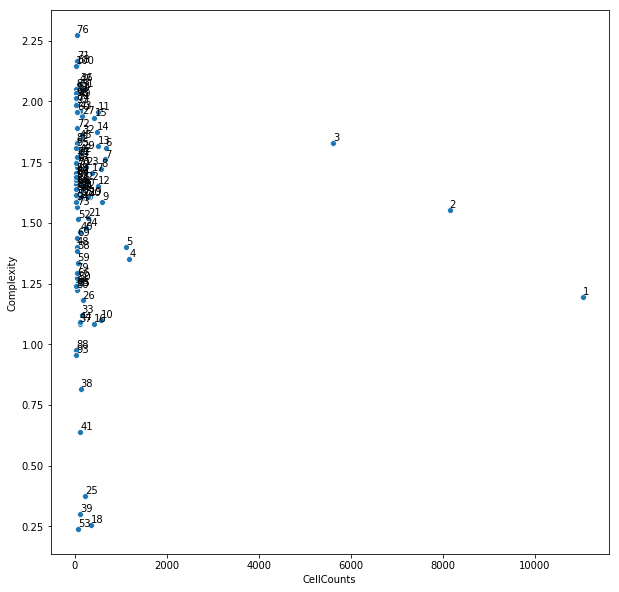

/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
/home/eecs/mattjones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2


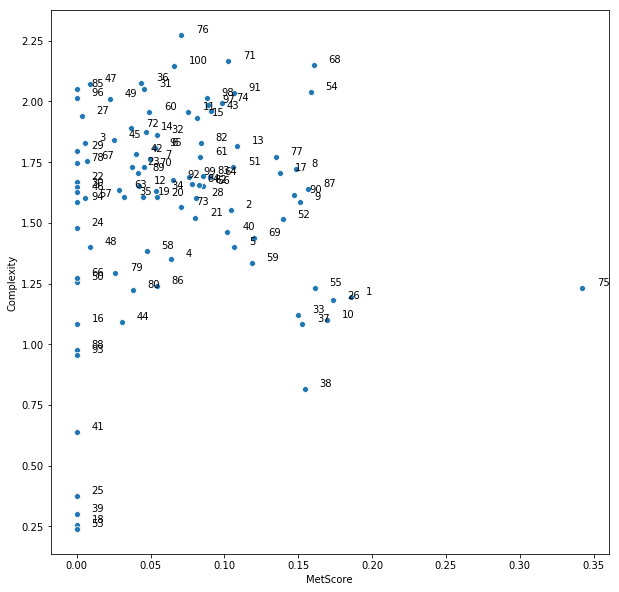

In [89]:
to_drop = list(tree_stats[(tree_stats["CutRate"] <= 0.15)].index)
to_drop += list(tree_stats[(tree_stats["UniqStates"]) <= 0.667].index)

print(set(to_drop), len(set(to_drop)))

# cut rate vs uniq states
h = plt.figure(figsize = (10,10))
sns.scatterplot(tree_stats['CutRate'], tree_stats['UniqStates'])
for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CutRate"]+0.01, tree_stats.loc[i, "UniqStates"] + 0.01))
plt.axvline(x = 0.15, color="red", linestyle="dashed")
plt.axhline(y = 0.667, color="black", linestyle="dashed")
plt.savefig('cutrate_vs_uniqstates.png')
plt.show()

# cut rate vs complexity
h = plt.figure(figsize = (10,10))
sns.scatterplot(tree_stats['CutRate'], -np.log2(tree_stats['Complexity']))
for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CutRate"] + 0.01, -np.log2(tree_stats.loc[i, "Complexity"])+0.01))
plt.savefig('cutrate_vs_complexity.png')
plt.show()


# complexity vs uniq states
h = plt.figure(figsize = (10,10))
sns.scatterplot(-np.log2(tree_stats['Complexity']), tree_stats['UniqStates'])
for i in tree_stats.index:
    plt.annotate(i, (-np.log2(tree_stats.loc[i, "Complexity"])+0.01, tree_stats.loc[i, "UniqStates"] + 0.01))
plt.savefig('complexity_vs_uniqstates.png')
plt.show()

# num leaves vs tree depth
h = plt.figure(figsize = (10,10))
sns.scatterplot(tree_stats['CellCounts'], tree_stats['Depths'])
for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CellCounts"]+0.01, tree_stats.loc[i, "Depths"] + 0.01))
plt.savefig('ncells_vs_depth.png')
plt.show()

# num leaves vs tree complexity
h = plt.figure(figsize = (10,10))
sns.scatterplot(tree_stats['CellCounts'], -np.log2(tree_stats['Complexity']))
for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CellCounts"]+0.01, -np.log2(tree_stats.loc[i, "Complexity"])+0.01))
plt.savefig('ncells_vs_complexity.png')
plt.show()

# tree met score vs complexity
h = plt.figure(figsize = (10,10))
sns.scatterplot(tree_stats['MetScore'], -np.log2(tree_stats['Complexity']))
for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "MetScore"]+0.01, -np.log2(tree_stats.loc[i, "Complexity"])+0.01))
plt.savefig('metscore_vs_complexity.png')
plt.show()

